In [57]:
# %%
import sklearn.metrics
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from math import ceil


# %%

# this is the number of real recorded EEG signal we used in the study platform we hosted. The signals were arranged in (real signals, simulated signals) order. Thus, num_real_sigs is used as an array offset in this analysis.
num_real_sigs = 49

# the simulated signals were presented in randomized order to each human labeler. The ordering was recorded as a list of indices.
# the selections the labelers made were recorded in the order they were selected.
# This function finds the index at which the desired signal index appears in the ordering of signal indices.
def reverse_order(j, order):
    for i in range(len(order)):
        if j == order[i]:
            return i
        
def decode_params(param_list) -> dict | None:
    if len(param_list) != 5:
        return None
    retDict = {}
    retDict["freq"]=2*param_list[0]
    retDict["n_cycles"] = param_list[1]
    retDict["rise-decay asymmetry"] = param_list[2]
    retDict["aperiodic exponent"] = param_list[3]
    retDict["signal-noise ratio"] = param_list[4]
    return retDict
    


In [58]:


# Load data from results json exported from firebase
with open("./voyteklabstudy-default-rtdb-export.json") as f:
    results = json.load(f)


# ground truth has shape (num_participants,2)
# it shows the correct bursting classification.
#ground_truth[i] = [a,b] where a is true burst onset and b is true burst offset.
ground_truth = np.array(results["ground_truth"])

# List of names of human collaborators who labeled data
# length of which gives us number of labelings. Allows us to iterate through labelers
who = list(results["selections"].keys())

'''
y_pred and y_true are variables for auc_roc
  we want to analyze humans as a whole.
  so y_pred is the interval the humans select (on average?)
  let's start with just one lab person.

'''


# Here we do not have burst labeling code because humans labeled the signals on a study labeling platform

# the classes are "bursting" and "non-bursting"
num_classes = 2

y_pred = np.zeros(
    (len(ground_truth), len(results['sigs']['sig_'+str(0)])))
y_true = np.zeros(
    (len(ground_truth), len(results['sigs']['sig_'+str(0)])))
scores=np.zeros(len(ground_truth))


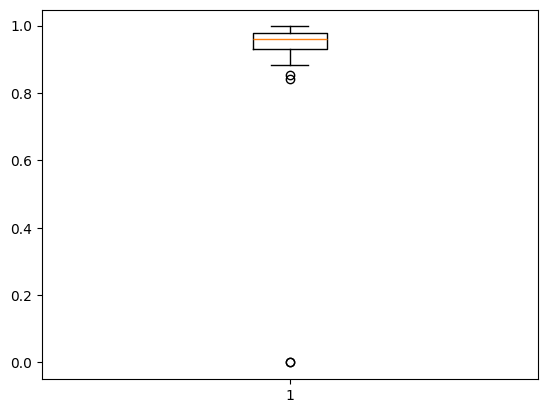

In [59]:

# iterates through each signal to create the y_pred[i] for signal i.
for ground_truth_signal_index in range(len(ground_truth)):
    signal_index = ground_truth_signal_index+num_real_sigs
    signal = results['sigs']['sig_'+str(
        ground_truth_signal_index+num_real_sigs)]
    
    # this loop records the quantity of labelers who each timepoint in signal i as bursting
    for labeler_index in range(len(who)):
        order = np.array(results["selections"][who[labeler_index]]['indices'])
        selections = np.array(results["selections"][who[labeler_index]]["selections"])

        # this block retrieves the signal selections that labeler j made on signal i.
        # then assigns this value to selections_indexed_by_labeler.
        reverse_search_sig_idx = reverse_order(ground_truth_signal_index + num_real_sigs, order)
        selections_indexed_by_labeler = selections[reverse_search_sig_idx]

        len_curr_sig = len(signal)

        # records ground truth for signal i in y_true[i].
        # The j==0 condition ensures that y_true isn't set repetitively.
        if labeler_index==0:
            for time_point in range(ground_truth[ground_truth_signal_index][0], ground_truth[ground_truth_signal_index][1]+1):
                y_true[ground_truth_signal_index][time_point] = 1
        
        for time_point in range(selections_indexed_by_labeler[0], selections_indexed_by_labeler[1]+1):
            # IN CONTEXT OF ALL ENCLOSING LOOPS, this line counts the number of people
            # who labeled this timepoint as containing a burst,
            # for all timepoints, labelers, and signals
            y_pred[ground_truth_signal_index][time_point] += 1

    

    consensus_threshold = ceil(len(who)/float(2))
    for timepoint in range(len(signal)):
        y_pred[ground_truth_signal_index][timepoint] = 1 if y_pred[ground_truth_signal_index][timepoint] >= consensus_threshold else 0

    scores[ground_truth_signal_index]=sklearn.metrics.f1_score(y_true=y_true[ground_truth_signal_index], y_pred = y_pred[ground_truth_signal_index])

plt.figure("f1 scores aggregated")
plt.boxplot(scores)
plt.show()


worst f1 score: 0.0
raw params: [6, 3, 0.32702859682013286, -1.0381511571552056, 0.4379600486953743]
decoded params: {'freq': 12, 'n_cycles': 3, 'rise-decay asymmetry': 0.32702859682013286, 'aperiodic exponent': -1.0381511571552056, 'signal-noise ratio': 0.4379600486953743}


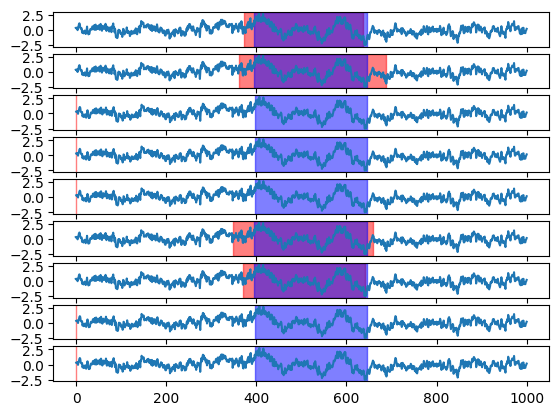

In [60]:

# identify the really bad signal.
max_val, bad_score_index = 1.0, -1
for ground_truth_signal_index in range(len(ground_truth)):
    if scores[ground_truth_signal_index] < max_val:
        max_val = scores[ground_truth_signal_index]
        bad_score_index = ground_truth_signal_index

print("worst f1 score:", scores[bad_score_index])
params = results["params"][bad_score_index]
print("raw params: %s" % str(params))
params = decode_params(params)
print("decoded params: %s" % params)

sig_bad_perf = results['sigs']['sig_'+str(
    bad_score_index+num_real_sigs)]
# this loop records the quantity of labelers who each timepoint in signal i as bursting
for labeler_index in range(len(who)):
    order = np.array(results["selections"][who[labeler_index]]['indices'])
    selections = np.array(results["selections"]
                          [who[labeler_index]]["selections"])

    # this block retrieves the signal selections that labeler j made on signal i.
    # then assigns this value to selections_indexed_by_labeler.
    reverse_search_sig_idx = reverse_order(
        bad_score_index + num_real_sigs, order)
    selections_indexed_by_labeler = selections[reverse_search_sig_idx]

    plt.subplot(len(who), 1, labeler_index+1)
    plt.plot(np.linspace(0, len_curr_sig, len_curr_sig),
             sig_bad_perf)
    plt.axvspan(
        selections_indexed_by_labeler[0], selections_indexed_by_labeler[1], color='red', alpha=0.5)
    plt.axvspan(ground_truth[bad_score_index][0],
                ground_truth[bad_score_index][1], color='blue', alpha=0.5)